Importing needed libraries

In [1]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as trfms
import torchsummary

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torch.amp import autocast, GradScaler
from datasets import load_from_disk
from tqdm import tqdm
from src.model import SwinTransformer
from src.utils import mask_from_pred

/home/denis/Coding/projects/TESTImageSegmentation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selecting CUDA device if available. Set multiprocessing method to 'spawn' instead of 'fork' as it works better on UNIX-system.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.multiprocessing.set_start_method('spawn', force=True)

Loading dataset

In [3]:
NUM_CLASSES = 34

dataset = load_from_disk("./data/urbansyncityscapes")
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

Some samples

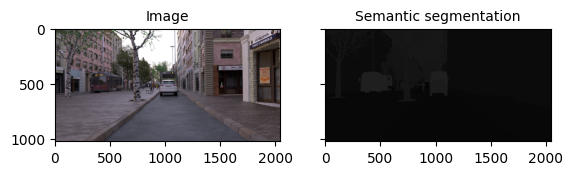

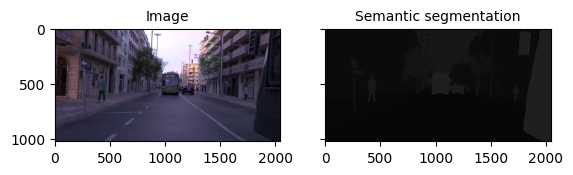

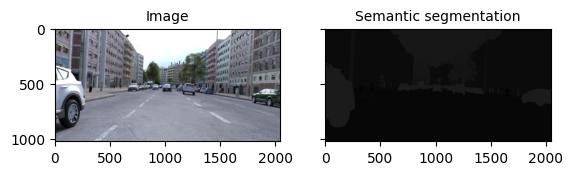

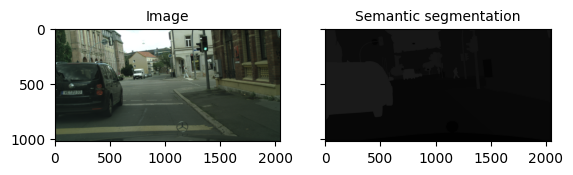

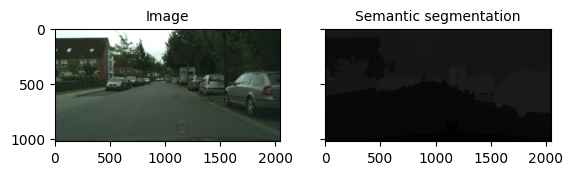

In [4]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    fig = plt.figure()
    ax1, ax2 = fig.subplots(1, 2, sharey=True)
    ax1.imshow(image)
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(semantic_segmentation)
    ax2.set_title('Semantic segmentation', fontsize='medium')


Specifying augmentation for train and validation set. Test set would be used without any augmentation. 

In [5]:
class InstanceAugmentation:
    """
    Transformation of both image and mask. Geometric transformation would be
    in alignment with each other. Color transformation is applied specifically
    for image.
    """
    def __init__(self, geometry_transform = None, color_transform = None):
        self.geometry_transform = geometry_transform
        self.color_transform = color_transform

    def __call__(self, image, mask):
        if self.geometry_transform:
            seed = random.randint(0, 2**32)
            torch.manual_seed(seed)
            image = self.geometry_transform(image)
            torch.manual_seed(seed)
            mask = self.geometry_transform(mask)

        if self.color_transform:
            image = self.color_transform(image)

        return image, mask

In [6]:
train_transforms_geometry = trfms.Compose([
    trfms.Resize(size=(512, 1024)),
    trfms.RandomHorizontalFlip(),
    trfms.RandomApply(transforms=[
        trfms.Resize(size=(512, 512))
    ], p=0.5),
    trfms.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.3))
])
train_transforms_color = trfms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.4, hue=0.3)

train_transform = InstanceAugmentation(train_transforms_geometry, train_transforms_color)

In [7]:
val_transforms_geometry = trfms.Compose([
    trfms.Resize(size=(512, 1024)),
    trfms.RandomHorizontalFlip(),
    trfms.RandomAffine(degrees=(-15, 15), scale=(0.8, 1.2)),
])
val_transforms_color = trfms.ColorJitter(brightness=0.1, contrast=0.1)

val_transform = InstanceAugmentation(val_transforms_geometry, val_transforms_color)

Augmented samples

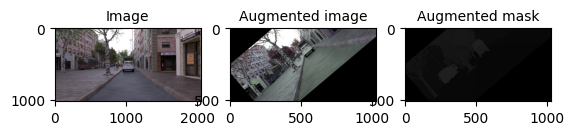

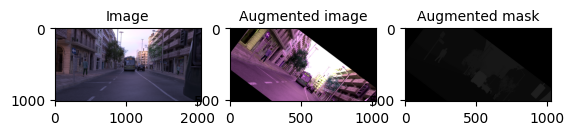

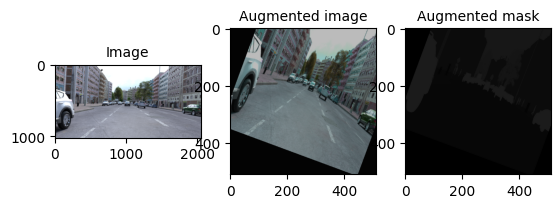

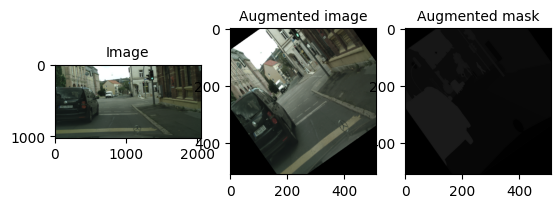

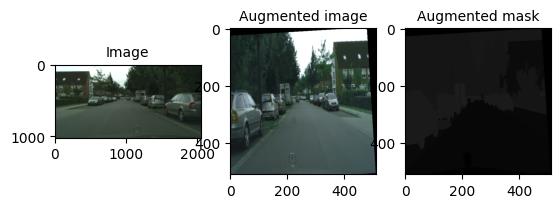

In [8]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    aug_image, aug_mask = train_transform(image, semantic_segmentation)
    fig = plt.figure()
    ax1, ax2, ax3 = fig.subplots(1, 3)
    ax1.imshow(np.array(image))
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(aug_image)
    ax2.set_title('Augmented image', fontsize='medium')
    ax3.imshow(aug_mask)
    ax3.set_title('Augmented mask', fontsize='medium')

Making a pytorch Dataset compatible with transformations 

In [9]:
def unwrap_mask(mask : torch.Tensor) -> torch.Tensor:
    assert len(mask.shape) == 2, f"Mask should be a tensor of shape (H, W), got {mask.shape}!"
    unwrapped = []
    for i in range(NUM_CLASSES):
        unwrapped.append((mask == i*torch.ones_like(mask)))
    return torch.stack(unwrapped, dim=-1).float().to(mask.device)

In [10]:
class StreetSegmentationDataset(Dataset):
    def __init__(self, dataset, transform  = None):
        super().__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx : int):
        sample = self.dataset[idx]
        image = sample['image']
        mask = sample['semantic_segmentation']

        if self.transform:
            image, mask = self.transform(image, mask)

        image = torch.Tensor(np.array(image)).float()/255
        mask = torch.Tensor(np.array(mask)).long()[:, :, 0]
        return image, mask

In [11]:
train_ds = StreetSegmentationDataset(dataset_train, train_transform)
val_ds = StreetSegmentationDataset(dataset_val, val_transform)
test_ds = StreetSegmentationDataset(dataset_test)

In [12]:
def collate_fn(batch):
    images, masks = zip(*batch)
    max_height = max(img.shape[0] for img in images)
    max_width = max(img.shape[1] for img in images)

    padded_images = []
    padded_masks = []
    original_sizes = []
    for img, mask in zip(images, masks):
        height, width, channels = img.shape
        padded_img = torch.zeros((max_height, max_width, channels), dtype=img.dtype)
        padded_img[:height, :width, :] = img

        padded_mask = torch.zeros((max_height, max_width), dtype=mask.dtype)
        padded_mask[:height, :width] = mask

        padded_images.append(padded_img)
        padded_masks.append(padded_mask)
        original_sizes.append((height, width))

    padded_images = torch.stack(padded_images, dim=0)
    padded_masks = torch.stack(padded_masks, dim=0)

    return padded_images, padded_masks, original_sizes

In [13]:
BATCH_SIZE = 4

train_dataloader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_dataloader = DataLoader(val_ds, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)

Using Swin Transformer architecture neural network

In [14]:
model = SwinTransformer(NUM_CLASSES, 48).to(device)
torchsummary.summary(model, (512, 1024, 3), batch_size=BATCH_SIZE, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 48, 256, 512]           1,344
            Conv2d-2            [4, 48, 37, 74]         112,944
    PatchEmbedding-3              [4, 2738, 48]               0
         LayerNorm-4              [4, 2738, 48]              96
MultiheadAttention-5  [[-1, 2738, 48], [-1, 2738, 2738]]               0
         LayerNorm-6              [4, 2738, 48]              96
            Linear-7             [4, 2738, 192]           9,408
              GELU-8             [4, 2738, 192]               0
            Linear-9              [4, 2738, 48]           9,264
        SwinBlock-10            [4, 48, 37, 74]               0
           Conv2d-11             [4, 48, 6, 11]         112,944
   PatchEmbedding-12                [4, 66, 48]               0
        LayerNorm-13                [4, 66, 48]              96
MultiheadAttention-14  [[-1, 6

Specifying loss function

In [15]:
cross_entropy_loss = nn.CrossEntropyLoss()

def loss_fn(y_pred : torch.Tensor, y_true : torch.Tensor):
    """
    Computes CrossEntropy Loss
    y_pred : torch.Tensor - Model prediction of shape (batch_size, height, width, num_classes), dtype=float
    y_true : torch.Tensor - Target mask of shape (batch_size, height, width), dtype=long
    """
    y_pred = y_pred.permute(0, 3, 1, 2)
    loss = cross_entropy_loss(y_pred, y_true)
    return loss


Specifying IntersectionOverUnion metrics function

In [16]:
def intersection_over_union(y_pred : torch.Tensor, y_true : torch.Tensor):
    """
    Computes IntersectionOverUnion metrics
    """
    pred_mask = mask_from_pred(y_pred, one_channel=True).long()
    intersection = (pred_mask & y_true).float().sum((1, 2))
    union = (pred_mask | y_true).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

Dictionary to keep loss and metrics during training and validation

In [17]:
history = {
    "train_loss" : [float('inf')],
    "train_iou" : [0.0],
    "val_loss" : [float('inf')],
    "val_iou" : [0.0]
}

Specifying training and validation algorithms

In [18]:
def train(model, dataloader, optimizer, scaler, scheduler = None, accumulation_steps : int = 8):
    model.train()
    pbar = tqdm(dataloader, f"Train loss: {history['train_loss'][-1]:.2f}, IoU: {history['train_iou'][-1]:.2f}")
    total_loss = 0
    out_of_mem = 0
    for batch_idx, (images, masks, _) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        try:
            with autocast('cuda'):
                prediction = model(images)
                loss_value = loss_fn(prediction, masks)
                iou_metrics = intersection_over_union(prediction, masks)

            scaler.scale(loss_value).backward()

            if (batch_idx+1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            if scheduler:
                scheduler.step(loss_value)

            history['train_loss'].append(loss_value.item())
            history['train_iou'].append(iou_metrics)
            total_loss += history['train_loss'][-1]
            if batch_idx % 10 == 0:
                pbar.set_description(f"Train loss: {history['train_loss'][-1]:.2f}, IoU: {history['train_iou'][-1]:.2f}")

        except RuntimeError as e:
            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e

        del images, masks
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    return total_loss/(batch_idx+1)

def validate(model, dataloader):
    model.eval()
    pbar = tqdm(dataloader, f"Validation loss: {history['val_loss'][-1]:.2f}, IoU: {history['val_iou'][-1]:.2f}")
    total_loss = 0
    out_of_mem = 0
    with torch.no_grad():
        for batch_idx, (images, masks, _) in enumerate(pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            try:
                prediction = model(images)
                loss_value = loss_fn(prediction, masks)
                iou_metrics = intersection_over_union(prediction, masks)

            except RuntimeError as e:
                if 'out of memory' in str(e):
                    out_of_mem += 1
                    torch.cuda.empty_cache()
                else:
                    raise e

            history['val_loss'].append(loss_value.item())
            history['val_iou'].append(iou_metrics)
            total_loss += history['val_loss'][-1]
            if batch_idx % 10 == 0:
                pbar.set_description(f"Validation loss: {history['val_loss'][-1]:.2f}, IoU: {history['val_iou'][-1]:.2f}")

            del images, masks
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")

    return total_loss/(batch_idx+1)

In [19]:
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
scaler = GradScaler()

In [ ]:
EPOCHS = 100
checkpoint_path = "./checkpoint"
os.makedirs(checkpoint_path, exist_ok=True)
best_val_loss = float('inf')

for i in range(EPOCHS):
    print(f"Training epoch: {i+1}/{EPOCHS}")
    mean_train_loss = train(model, train_dataloader, optimizer, scaler, scheduler)
    print(f"Average training loss: {mean_train_loss:.2f}")
    mean_val_loss = validate(model, val_dataloader)
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        checkpoint_file = os.path.join(checkpoint_path, f'swin_seg_best.pth')
        torch.save(model.state_dict(), checkpoint_file)
        print(f"New best model saved with val_loss: {best_val_loss:.2f} at {checkpoint_file}")
    else:
        print(f"No improvement in validation loss ({mean_val_loss:.2f})")


Training epoch: 1/100


Train loss: 3.38, IoU: 0.00: 100%|█████████▉| 1926/1928 [36:33<00:02,  1.08s/it]